# Glacier speed inset plot

In [19]:
import rasterio as rio
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pyproj
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar

import sys
sys.path.append("../velocity/")
import datacube_tools

## Load background image

In [7]:
with rio.open("./data/composite.tif", mode="r") as ds:
    img = ds.read([1,2,3])
    left, bottom, right, top = ds.bounds
    xfrm = ds.transform
    crs = ds.crs

img = np.moveaxis(img, 0, -1)

## Download velocity points

In [8]:
def build_mask(dcube, sat_filt, start_date, stop_date, baseline_mask):
    """
    Build velocity mask for inversion based on NaNs, satellite choices, and a date range

    Parameters
    ----------
    dcube - velocity datecube
    sat_filt - list of satellites to use
    start_date - start date for inversion
    stop_date - stop date for inversion
    baseline_mask - tuple specifying high and low baseline bounds in integer days

    Returns
    ------
    mask - Boolean mask for time axis of velocity datacube
    """
    # Remove all-nan timesteps, use vx
    if len(dcube.vx.shape) == 3:
        # supress stupid nanmean warning
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mask = np.logical_not(
                np.isnan(np.nanmean(np.nanmean(dcube.vx, axis=1), axis=1))
            )
    elif len(dcube.vx.shape) == 1:
        mask = np.logical_not(np.isnan(dcube.vx))

    # Satellite filter
    if sat_filt is not None:
        mask = np.logical_and(
            mask,
            np.logical_and(
                np.in1d(dcube.satellite_img1, sat_filt),
                np.in1d(dcube.satellite_img2, sat_filt),
            ),
        )

    # Start date filter
    if start_date is not None:
        tstart = np.datetime64(start_date)
        mask = np.logical_and(mask, dcube.acquisition_date_img1 >= tstart)

    # Stop date filter
    if stop_date is not None:
        tstop = np.datetime64(stop_date)
        mask = np.logical_and(mask, dcube.acquisition_date_img2 <= tstop)

    # Baseline filter
    baseline = (dcube.acquisition_date_img2 - dcube.acquisition_date_img1).dt.days
    
    if(baseline_mask[0] is not None):
        mask = np.logical_and(mask, baseline > baseline_mask[0])

    if(baseline_mask[1] is not None):
        mask = np.logical_and(mask, baseline < baseline_mask[1])
    
    return mask


In [9]:
xv = [587500, 583500, 587500, 592500, 594200]
yv = [6662000, 6653000, 6656000, 6659000, 6665000]

xform = pyproj.Transformer.from_crs(crs, "3413")
xvp, yvp = xform.transform(xv, yv)

pointvs = []
pointts = []

#sat_filt=["1A", "1B"]
sat_filt = ["1A", "1B", "2A", "2B", "4", "5", "7", "8", "9"]
start_date="2019-10-01"
stop_date="2022-10-01"
baseline_mask = (4, 100)

for i in range(len(xv)):
    # Download point date
    dc = datacube_tools.DATACUBETOOLS()
    xfull, xpnt, xy = dc.get_timeseries_at_point(
        (xvp[i], yvp[i]),
        "3413",
        variables=[
            "vx",
            "vy",
            "satellite_img1",
            "satellite_img2",
            "acquisition_date_img1",
            "acquisition_date_img2",
        ],
    )

    xpnt = xpnt.sortby("mid_date")

    # Build mask
    mask = build_mask(xpnt, sat_filt, start_date, stop_date, baseline_mask)
    
    # Apply mask to velocity grid
    vx_mask = xpnt["vx"][mask].to_numpy()[:, np.newaxis, np.newaxis]
    vy_mask = xpnt["vy"][mask].to_numpy()[:, np.newaxis, np.newaxis]

    pointvs.append(np.sqrt(vx_mask**2 + vy_mask**2)[:,0,0])
    pointts.append(xpnt.mid_date[mask].to_numpy())

original xy (-3303348.623608032, 255750.6748639145) 3413 maps to datacube (-3303348.623608032, 255750.6748639145) EPSG:3413
original xy (-3312236.7259546896, 260832.19195388662) 3413 maps to datacube (-3312236.7259546896, 260832.19195388662) EPSG:3413
original xy (-3309553.5699705086, 256379.89281809967) 3413 maps to datacube (-3309553.5699705086, 256379.89281809967) EPSG:3413
original xy (-3306974.7077743006, 250894.44132246904) 3413 maps to datacube (-3306974.7077743006, 250894.44132246904) EPSG:3413
original xy (-3300948.2625022153, 248508.92318019856) 3413 maps to datacube (-3300948.2625022153, 248508.92318019856) EPSG:3413


## Load velocity cube

In [10]:
ds = xr.load_dataset("./data/Hubbard_S1.nc")

# Make speed cube
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)

# Resample to daily positions
ds = ds.resample(time="1D").interpolate("cubic")

## Sample velocity dataset

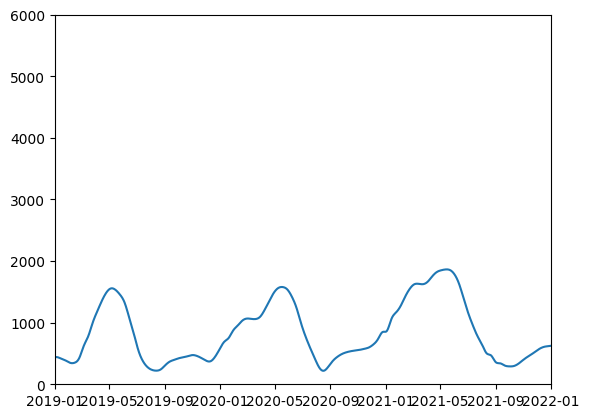

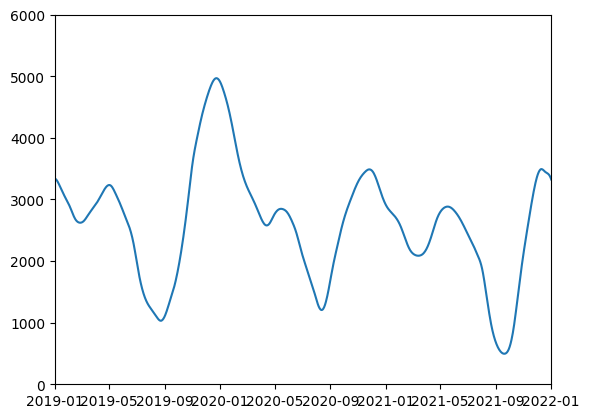

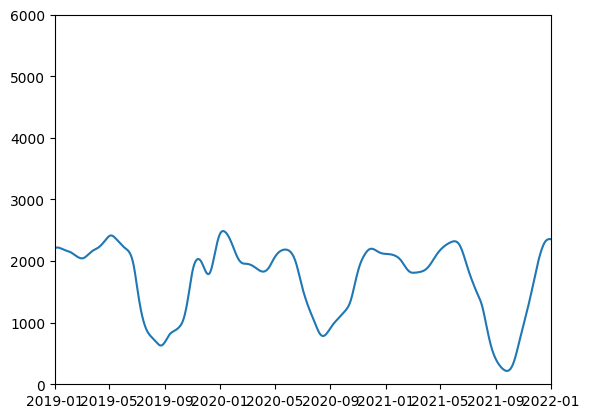

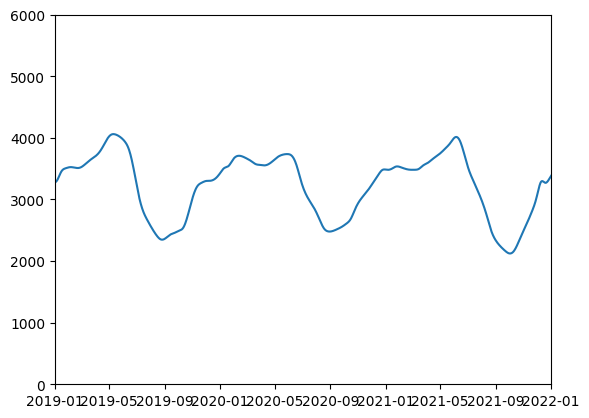

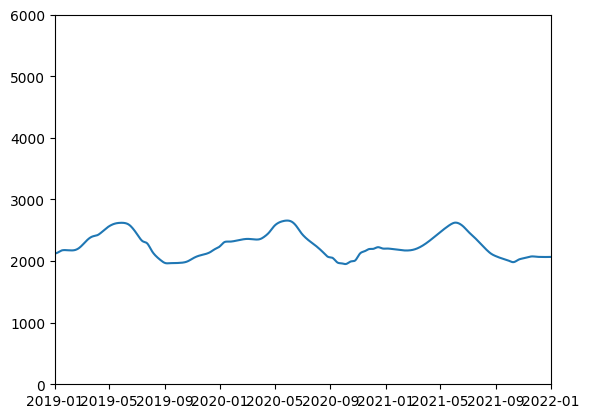

In [11]:
xv = [587500, 583500, 587500, 592500, 594200]
yv = [6662000, 6653000, 6656000, 6659000, 6665000]

xform = pyproj.Transformer.from_crs(crs, "3413")

xvp, yvp = xform.transform(xv, yv)

vts = []
for x, y in zip(xvp, yvp):
    # Get pixel x y
    px = np.argmin(np.abs(ds.x.to_numpy()-x))
    py = np.argmin(np.abs(ds.y.to_numpy()-y))
    vts.append(ds.v[:, py, px])
    plt.figure()
    plt.plot(ds.time, ds.v[:, py, px])
    plt.xlim(np.datetime64("2019"), np.datetime64("2022"))
    plt.ylim(0, 6e3)

## Make figure

/Users/amyjenson/miniconda3/envs/pseudo_base/lib/python3.12/site-packages/geopandas/plotting.py:494: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.draw()
/var/folders/rt/dpn4clx9381fwc243glrmcvm0000gp/T/ipykernel_57311/1275722453.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("hubbard_inset.png", dpi=300, bbox_inches="tight")
/Users/amyjenson/miniconda3/envs/pseudo_base/lib/python3.12/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/amyjenson/miniconda3/envs/pseudo_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


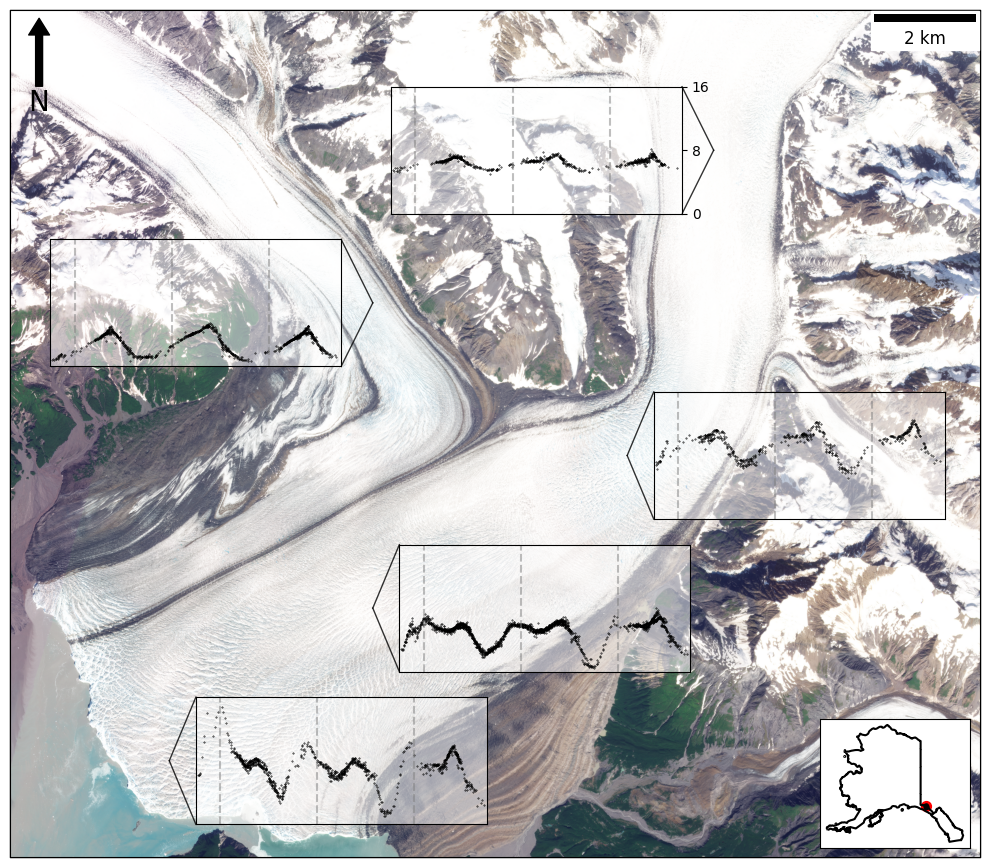

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(10,10), tight_layout=True)

# Plot basemap
ax.imshow(img, extent=[left, right, bottom, top])

# 1:1 aspect ratio
ax.set_aspect(1)

fs = 12 

# Remove axis labels
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Add border
ax.patch.set_edgecolor("black")
ax.patch.set_linewidth(1)

# Shrink extents to remove basemap edges
shrink = 2e3
ax.set(xlim=(left+1.5*shrink, right-0.25*shrink), ylim=(bottom+1.5*shrink, top-1.25*shrink))

##############
# Add a north arrow
arrow_x, arrow_y, arrow_length = 0.03, 0.99, 0.1
ax.annotate('N', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# ########################
# # add inset map

# Read the CSV file into a DataFrame
df = gpd.read_file("./basemap/Alaska_outline_cropped.shp")
df = df.to_crs(epsg=32607)

# Add a subplot with a black background
ax_map = fig.add_axes([0.825, 0.075, 0.15, 0.15], facecolor="white")

# Plot the shapefile on the map subplot
df.plot(ax=ax_map, color="black")
#ax_map.scatter([0.9], [0.5], alpha=1, c="red", s=1)
# Highlight a specific location (example coordinates)
highlight_x = arrow_x = 595750
highlight_y = 6660000
ax_map.scatter([highlight_x], [highlight_y], alpha=1, color="red", s=50)

# ax_map.axis('off')
# Turn off the ticks and axis labels
ax_map.tick_params(
    axis="both", which="both", bottom=False, top=False, left=False, right=False
)
ax_map.set_xticks([])
ax_map.set_yticks([])

# ########################
# Add a scale bar to the plot
scalebar = ScaleBar(
    1, location="upper right", font_properties={"size": fs}
)  # , frameon=False, font_properties={'family': 'serif', 'size': fs})
ax.add_artist(scalebar)

# #######################

# # Add velocity insets
axis_to_data = ax.transAxes + ax.transData.inverted()
data_to_axis = axis_to_data.inverted()
#dx = [-0.28, 0.03, 0.03, 0.03, -0.28]
dx = [-0.33, 0.03, 0.03, 0.03, -0.33]
for i in range(len(xv)):
    # Plot sample point
    plt.plot(xv[i], yv[i], 'k.', alpha=0.8)

    # Get axis coordinate for data points
    xa, ya = data_to_axis.transform([xv[i], yv[i]])
    axi = ax.inset_axes([xa+dx[i], ya-0.075, 0.3, 0.15])
    #axi = ax.inset_axes([1.05, ya-0.05, 0.25, 0.1])

    if(i in [0, 4]):
        xi0, yi0 = axis_to_data.transform([xa+dx[i]+0.3, ya-0.075])
        xi1, yi1 = axis_to_data.transform([xa+dx[i]+0.3, ya+0.075])
    else:
        xi0, yi0 = axis_to_data.transform([xa+dx[i], ya-0.075])
        xi1, yi1 = axis_to_data.transform([xa+dx[i], ya+0.075])
    xi, yi = axis_to_data.transform([1.05, ya])
    ax.plot([xv[i]+50, xi0], [yv[i], yi0], 'k-', alpha=0.8, linewidth=1)
    ax.plot([xv[i]+50, xi1], [yv[i], yi1], 'k-', alpha=0.8, linewidth=1)

    # unit conversion
    ufac = 365
    
    # Turn off axis labels
    axi.get_xaxis().set_visible(False)
    if(i != 4):
        axi.get_yaxis().set_visible(False)
    else:
        axi.get_yaxis().set_ticks([0, 8*ufac, 16*ufac])
        axi.get_yaxis().set_ticklabels([0, 8, 16])
        axi.get_yaxis().set_label_position("right")
        axi.get_yaxis().tick_right()
    
    # Make background transparent
    #axi.patch.set_facecolor("white")
    axi.patch.set_alpha(0.5)

    # Plot velocity
    #axi.plot(ds.time, vts[i], "r-", linewidth=0.75)
    axi.plot(pointts[i], pointvs[i], "k.", markersize=0.75)
    axi.axvline(np.datetime64("2020-01-01"), color="grey", linestyle="dashed", alpha=0.5)
    axi.axvline(np.datetime64("2021-01-01"), color="grey", linestyle="dashed", alpha=0.5)
    axi.axvline(np.datetime64("2022-01-01"), color="grey", linestyle="dashed", alpha=0.5)
    axi.set_xlim(np.datetime64("2019-10"), np.datetime64("2022-10"))
    axi.set_ylim(0, 16*ufac)

fig.savefig("hubbard_inset.png", dpi=300, bbox_inches="tight")